<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [201]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [202]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-17 18:30:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-08-17 18:30:40 (12.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [203]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [204]:
df.shape

(346, 10)

### Convert to date time object 

In [205]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [206]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [207]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



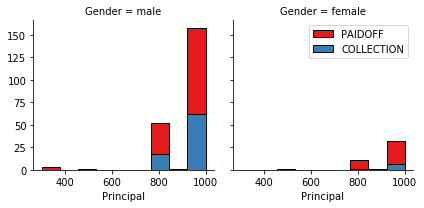

In [208]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

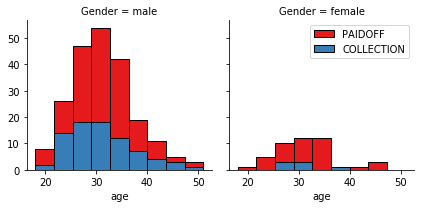

In [209]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

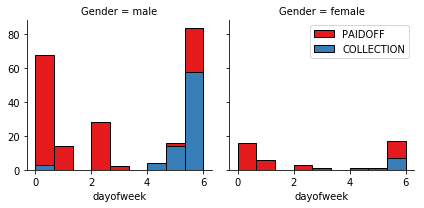

In [210]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [211]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [212]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [213]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [214]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [215]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [216]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [217]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [218]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [219]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [220]:
# What does the dataset currently look like:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [221]:
# Import the needed local Libraries
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score

In [222]:
# Create the Training and Test Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [223]:
# Create the KNN Model
kValue = range(1, 10)
knnAccuracy = []

for n in kValue:
    knnModel  = knn(n_neighbors = n)
    knnModel.fit(X_train, y_train)
    knn_yhat = knnModel.predict(X_test)
    knnAccuracy.append(accuracy_score(y_test, knn_yhat))

Text(0, 0.5, 'Accuracy Values')

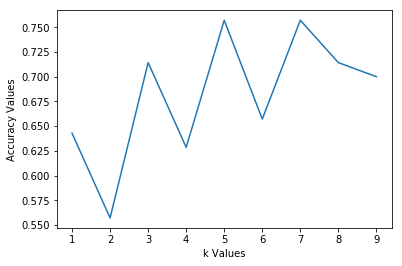

In [224]:
# Plot K Values vs Accuracy Score
plt.plot(kValue, knnAccuracy)
plt.xlabel('k Values')
plt.ylabel('Accuracy Values')

In [225]:
# Display the highest value of K
for i in range(0, len(mean_accuracy)):
    print("For k = {}, the accuracy = {} .".format(i+1, knnAccuracy[i]))

For k = 1, the accuracy = 0.6428571428571429 .
For k = 2, the accuracy = 0.5571428571428572 .
For k = 3, the accuracy = 0.7142857142857143 .
For k = 4, the accuracy = 0.6285714285714286 .
For k = 5, the accuracy = 0.7571428571428571 .
For k = 6, the accuracy = 0.6571428571428571 .
For k = 7, the accuracy = 0.7571428571428571 .
For k = 8, the accuracy = 0.7142857142857143 .
For k = 9, the accuracy = 0.7 .


In [226]:
# With a Maximum Value of 7, Create the final KNN Model
knnModel = knn(n_neighbors = 7)
knnModel.fit(X_train, y_train)
knn_yhat = knnModel.predict(X_test)

knnModel

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree

In [227]:
# Import the needed local libraries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [228]:
# Create Jaccard and F1 Score Objects
depthRange = range(1, 12)
jaccardSimilarityScore = []
f1Score = []

# For Varying Depths, calculate jaccard similarity and f1 scores
for n in depthRange:
    dTree = DecisionTreeClassifier(criterion = 'gini', max_depth = n)
    dTree.fit(X_train, y_train)
    dTree_yhat = dTree.predict(X_test)
    jaccardSimilarityScore.append(jaccard_similarity_score(y_test, dtree_yhat))
    f1Score.append(f1_score(y_test, dTree_yhat, average = 'weighted'))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [229]:
# Present the resulting data in a DataFrame
dTree_result = pd.DataFrame([jaccardSimilarityScore, f1Score], 
                             index = ['Jaccard Sim', 'F1'], columns = ['d = 1','d = 2','d = 3','d = 4','d = 5','d = 6','d = 7','d = 8','d = 9', 'd = 10', 'd = 11'])
dTree_result.columns.name = 'Depths'
dTree_result

Depths,d = 1,d = 2,d = 3,d = 4,d = 5,d = 6,d = 7,d = 8,d = 9,d = 10,d = 11
Jaccard Sim,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286
F1,0.750893,0.750893,0.736508,0.694760,0.657958,0.676571,0.722768,0.740048,0.742857,0.697975,0.735065


In [230]:
# With a Maximum Depth of 2, create the final Decision Tree Model
dTreeModel = DecisionTreeClassifier(criterion = 'gini', max_depth = 2)
dTreeModel.fit(X_train, y_train)
dTreeModel

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

In [103]:
#Import the needed local libraries
from sklearn.svm import SVC 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

# Since the plots will involve Matplotlib features, we need to import that library as well
import matplotlib.pyplot as plt
%matplotlib inline

In [231]:
# Create Kernel and Accuracy Score Objects
kernelFunction = ['linear', 'poly', 'rbf', 'sigmoid']
svmAccuracy = []

# For different functions, calculate the accuracy scores

for n in kernelFunction:
    svmModel = SVC(C = 0.01, gamma = 'auto', kernel = n)
    svmModel.fit(X_train, y_train)
    svm_yhat = svcModel.predict(X_test)
    svmAccuracy.append(f1_score(y_test, svm_yhat, average = 'weighted'))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'SVM Accuracy Score')

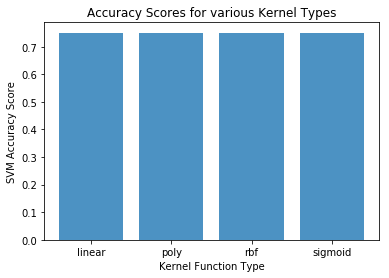

In [232]:
# Plot the Kernels vs Accuracy Scores
yPosition = np.arange(len(kernelFunction))
plt.bar(yPosition, svmAccuracy, align='center', alpha = 0.8)
plt.xticks(yPosition, kernelFunction)
plt.title('Accuracy Scores for various Kernel Types')
plt.xlabel('Kernel Function Type')
plt.ylabel('SVM Accuracy Score')

In [233]:
# Display the highest accuracy score for different kernel types
for i in range(0, len(svmAccuracy)):
    print("For kernel function type: {}, accuracy is {}.".format(i+1, svmAccuracy[i]))

For kernel function type: 1, accuracy is 0.7508928571428571.
For kernel function type: 2, accuracy is 0.7508928571428571.
For kernel function type: 3, accuracy is 0.7508928571428571.
For kernel function type: 4, accuracy is 0.7508928571428571.


In [234]:
# With a best value coming from 'rbf' (given the data type it is best choice among equals) , create the final SVM Model
svmModel = SVC(C = 0.01, gamma = 'auto', kernel = 'rbf')
svmModel.fit(X_train, y_train)
svmModel

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [236]:
# Import the needed local libraries
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss

# Since the plots will involve Matplotlib features, we need to import that library as well
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
# Create Solver and Accuracy Score Objects
solverList = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
regularizationValueSet = [0.1, 0.01, 0.001]
index = []
lrAccuracy = []
iterations = 0

for p, q in enumerate(regularizationValueSet):
    for r, s in enumerate(solverList):
        index.append(p + r *5)
        iterations +=1
        lrModel = LogisticRegression(C = q, solver = solver)
        lrModel.fit(X_train, y_train)
        lr_yhat = lrModel.predict(X_test)
        y_prob = lrModel.predict_proba(X_test)
        print('Test {}: With C = {} for solver = {}, LR Accuracy is : {}.'.format(iterations, q, s, log_loss(y_test, y_prob) ))
        lrAccuracy.append(log_loss(y_test, y_prob))

Test 1: With C = 0.1 for solver = lbfgs, LR Accuracy is : 0.43437257543838126.
Test 2: With C = 0.1 for solver = saga, LR Accuracy is : 0.43437572817090525.
Test 3: With C = 0.1 for solver = liblinear, LR Accuracy is : 0.43436024889204006.
Test 4: With C = 0.1 for solver = newton-cg, LR Accuracy is : 0.4343661998748489.
Test 5: With C = 0.1 for solver = sag, LR Accuracy is : 0.4343705168337158.
Test 6: With C = 0.01 for solver = lbfgs, LR Accuracy is : 0.4529047088207766.
Test 7: With C = 0.01 for solver = saga, LR Accuracy is : 0.45290905724628877.
Test 8: With C = 0.01 for solver = liblinear, LR Accuracy is : 0.4528885216026834.
Test 9: With C = 0.01 for solver = newton-cg, LR Accuracy is : 0.4528967706799613.
Test 10: With C = 0.01 for solver = sag, LR Accuracy is : 0.45289205437275726.
Test 11: With C = 0.001 for solver = lbfgs, LR Accuracy is : 0.4786940839885825.
Test 12: With C = 0.001 for solver = saga, LR Accuracy is : 0.47873488953788745.
Test 13: With C = 0.001 for solver = 

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

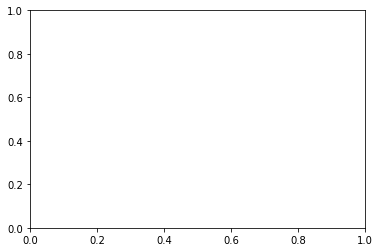

In [238]:
# Plot the Logistic Regression Accuracy Scores for different solver types
lrProbability = lrModel.predict_proba(X_test)
log_loss(y_test, lrProbability)
plt.plot(index, accuracy_score)
plt.title('LR Accuracy vs. Solver Type')
plt.xlabel('Parameter Value')
plt.ylabel('LR Accuracy')

In [239]:
# With 'liblinear' giving the highest accuracy score, we create the final LR model
lrModel = LogisticRegression(C = 0.001, solver = 'liblinear')
lrModel.fit(X_train, y_train)
lrModel

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [240]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [241]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-17 18:47:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-17 18:47:15 (359 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [242]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [243]:
# Convert Data-Time Objects
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Convert Day of Week Field
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# Convert Weekend Field
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Convert Education Level Field
testFeature = test_df[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
testFeature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,female,0,1,0,0
1,300,7,35,male,1,0,0,0
2,1000,30,43,female,1,0,1,0
3,1000,30,26,male,1,0,0,1
4,800,15,29,male,1,1,0,0


In [244]:
# Normalize the Test Data
testFeature_x = preprocessing.StandardScaler().fit(testFeature).transform(testFeature)
testFeature_x[0:5]

# Define the Target Result
testFeature_y = test_df['loan_status'].values
testFeature_y[0:5]

ValueError: could not convert string to float: 'female'

In [245]:
# Find Jaccard and f1 Scores for each algorithm
# K-Nearest Neighbor
knn_yhat = knnModel.predict(testFeature_x)
jss_knn=jaccard_similarity_score(testFeature_y, knn_yhat)
f1_knn=f1_score(TestY, knn_yhat, average='weighted')

# Decision Trees
dTree_yhat=dTreeModel.predict(testFeature_x)
jss_dTree=jaccard_similarity_score(testFeature_y, dTree_yhat)
f1_dTree=f1_score(testFeature_y, dTree_yhat, average='weighted')

# Single Vector Machine
svm_yhat=svmModel.predict(testFeature_x)
jss_svm=jaccard_similarity_score(testFeature_y, svm_yhat)
f1_svm=f1_score(testFeature_y, svm_yhat, average='weighted')

# Logistic Regression
lr_yhat=lrModel.predict(testFeature_x)
lr_probability=lrModel.predict_proba(testFeature_x)
jss_lr=jaccard_similarity_score(testFeature_y, lr_yhat)
f1_lr=f1_score(testFeature_y, lr_yhat, average='weighted')  
logloss_lr=log_loss(testFeature_y, lr_probability)

# Collate Results for JSS, F1 and LogLoss into a Array
list_jss = [jss_knn, jss_dTree, jss_svm, jss_lr]
list_f1 = [f1_knn, f1_dTree, f1_svm, f1_lr]
list_logloss = ['Undef', 'Undef', 'Undef', logloss_lr]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [246]:
# Put all the data into a Table for the Report
df = pd.DataFrame(list_jc, index=['KNN','Decision Tree','SVM','LogisticRegression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm Type'
df

Algorithm Type,Jaccard,F1-score,LogLoss
KNN,0.722222,0.710576,Undef
Decision Tree,0.740741,0.630418,Undef
SVM,0.740741,0.630418,Undef
LogisticRegression,0.777778,0.755227,0.669325


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>